# Berufsrisiko Corona

### Analyse des Ansteckungsrisiko nach Geschlecht und Einkommen

In [344]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---

### Daten einlesen und bereinigen

In [550]:
# import data
soc10_isco08 = pd.read_stata("input/onetsoc_to_isco_cws_ibs/soc10_isco08.dta")
exposure = pd.read_csv("input/Exposed_to_Disease_or_Infections.csv")
proximity = pd.read_csv("input/Physical_Proximity.csv")
salary = pd.read_excel("input/je-d-03.04.01.02.47.xlsx", skiprows=5)
gender = pd.read_excel("input/su-d-40.02.03.02.01.03.10.xlsx", sheet_name="2018", skiprows=5)

In [551]:
# rename columns and drop unused data
salary.columns = ['ISCO', 'Beruf', 'Unnamed: 2', 'Alle-Total', 'Alle-Frauen', 'Alle-Männer',
       'bis29-Total', 'bis29-Frauen', 'bis29-Männer', '30-49-Total', '30-49-Frauen',
       '30-49-Männer', 'ab50-Total', 'ab50-Frauen', 'ab50-Männer']
salary = salary.iloc[2:49,:]
salary = salary.drop(columns=["Unnamed: 2"])

gender.columns = ['Berufshauptgruppe', 'Berufsgruppe', 'Berufsuntergruppe',
                  'Berufsgattung', 'Berufsart', 'Bezeichnung', 'Total (in T)', 'Männer (in T)',
                  'Frauen (in T)', 'Schweizer (in T)', 'Ausländer (in T)']
gender = gender.iloc[:1484,:]

In [553]:
# Limit to Berufsgattung (ISCO lvl4)
gender = gender[~pd.isnull(gender.Berufsgattung )].drop(columns=["Berufshauptgruppe", "Berufsgruppe", "Berufsuntergruppe", "Berufsart"])
# Keep only subcategories
salary = salary[salary.ISCO.str.len() == 2]

In [554]:
# define NAs and change type of variable
gender = gender.replace('X', np.nan)
gender.Berufsgattung = gender.Berufsgattung.astype(float)
exposure['Context'] = exposure['Context'].replace("Not available", np.nan).astype('float')

In [555]:
# calculate share of women and share of foreigners per job
gender['Frauenanteil'] = 100 - (100 / gender['Total (in T)'] * gender['Männer (in T)'])
for index, job in gender[pd.isnull(gender['Frauenanteil'])].iterrows():
    gender.loc[index,'Frauenanteil'] = 100 / job['Total (in T)'] * job['Frauen (in T)']
gender['Auslaenderanteil'] = 100 - (100 / gender['Total (in T)'] * gender['Schweizer (in T)'])
gender = gender.drop(columns=['Männer (in T)', 'Frauen (in T)', 'Schweizer (in T)', 'Ausländer (in T)'])

---

## Frauenanteile

### Übersetze von SOC- zu ISCO-Kodierung und fassen neue Daten in DataFrame `data` zusammen

In [556]:
# clean SOC
exposure['soc'] = exposure.Code.apply(lambda x: x[:-3].replace("-",""))
proximity['soc'] = proximity.Code.apply(lambda x: x[:-3].replace("-",""))

In [557]:
# create function to match SOC to ISCO
def soc_to_isco(soc):
    if len(soc10_isco08.loc[soc10_isco08.soc10 == int(soc), "isco08"]) > 0:
        return soc10_isco08.loc[soc10_isco08.soc10 == int(soc), "isco08"].values[0]
    else:
        return np.nan

In [558]:
# apply soc_to_isco()
exposure['isco08'] = exposure['soc'].apply(soc_to_isco)
proximity['isco08'] = proximity['soc'].apply(soc_to_isco)

In [561]:
# create new dataframe, match (average of) exposure- and proximity-values and calculate exp_prox (Ansteckungsrisiko)
data = gender.copy()
for index, job in data.iterrows():
    data.loc[index, "Exposure"] = exposure[exposure.isco08 == job["Berufsgattung"]]["Context"].mean()
    data.loc[index, "Proximity"] = proximity[proximity.isco08 == job["Berufsgattung"]]["Context"].mean()
data['Exp_Prox'] = (data['Exposure'] + data['Proximity'])/2

---

### `data` überprüfen und bereinigen

In [562]:
# extract ISCO Berufsgruppencode
data["ISCO_kurz"] = data.Berufsgattung.astype("str").apply(lambda x: x[:-4] if len(x) == 6 else "0"+x[:-4])

In [563]:
# n of Total earners
data["Total (in T)"].sum()

4357.6137996248835

In [564]:
# n of earners with exposure-values
data[~pd.isnull(data.Exposure)]["Total (in T)"].sum()

3543.9037344465296

In [646]:
## limit data to jobs which have a number of earners assigned to it
data = data[~pd.isnull(data['Total (in T)'])]

In [567]:
# flag data which has exp_prox-values assigned
data['Orig_Source'] = 1
data.loc[pd.isnull(data['Exp_Prox']),'Orig_Source'] = 0

In [569]:
# for all the others: calculate proximity, exposure und exp_prox based on related jobs
for index, job in data[data.Orig_Source == 0].iterrows():
    proximity_value = data[(data.ISCO_kurz == job['ISCO_kurz']) & (data.Orig_Source == 1)].Proximity.mean()
    exposure_value = data[(data.ISCO_kurz == job['ISCO_kurz']) & (data.Orig_Source == 1)].Exposure.mean()
    exp_prox_value = data[(data.ISCO_kurz == job['ISCO_kurz']) & (data.Orig_Source == 1)].Exp_Prox.mean()
    data.loc[index, "Proximity"] = proximity_value
    data.loc[index, "Exposure"] = exposure_value
    data.loc[index, "Exp_Prox"] = exp_prox_value

In [630]:
# again: n of earners with exposure-values
data[~pd.isnull(data['Exp_Prox'])]["Total (in T)"].sum()

4077.635430287547

---

### Korrelationen berechnen und Verteilung der Werte anschauen 

In [570]:
# calc correlation between 'Frauenanteil' and 'Exp_Prox'
data[['Frauenanteil', 'Exp_Prox']].corr()

,Frauenanteil,Exp_Prox
Frauenanteil,1.000000,0.409801
Exp_Prox,0.409801,1.000000


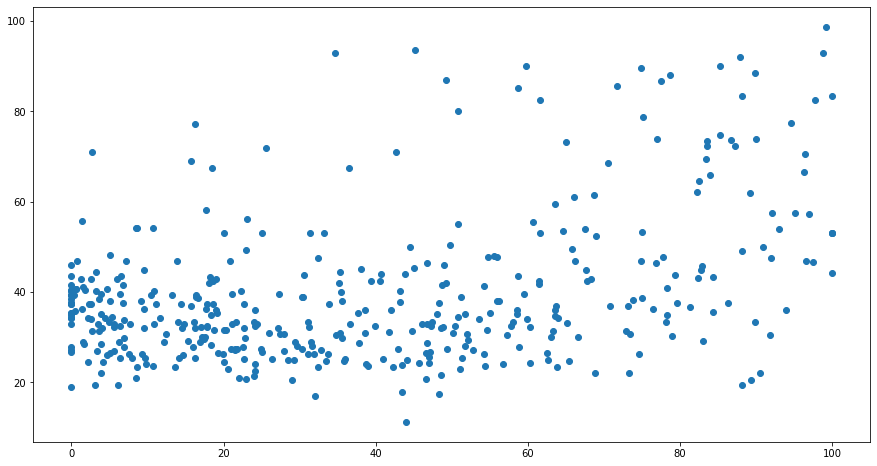

In [572]:
# quick look at data
plt.figure(figsize=(15,8))
plt.plot(data['Frauenanteil'], data['Exp_Prox'], 'o')

In [573]:
# calc correlation between 'Frauenanteil' and 'Exposure'
data[['Frauenanteil', 'Exposure']].corr()

,Frauenanteil,Exposure
Frauenanteil,1.000000,0.439893
Exposure,0.439893,1.000000


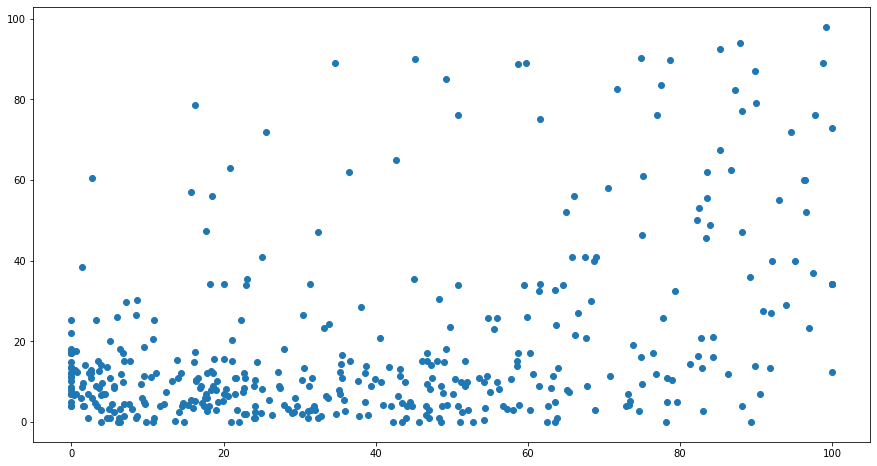

In [575]:
# Another quick look at the data
plt.figure(figsize=(15,8))
plt.plot(data['Frauenanteil'], data['Exposure'], 'o')

In [576]:
# calc correlation between 'Frauenanteil' and 'Proximity'
data[['Frauenanteil', 'Proximity']].corr()

,Frauenanteil,Proximity
Frauenanteil,1.000000,0.258492
Proximity,0.258492,1.000000


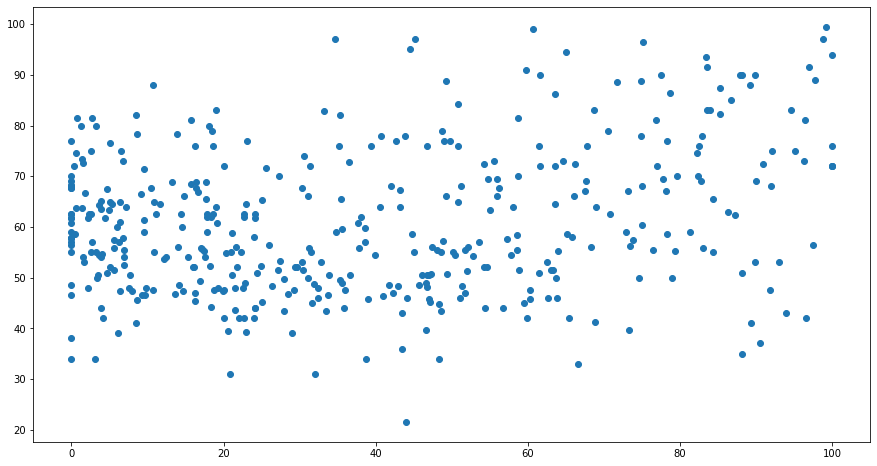

In [578]:
# look at distribution
plt.figure(figsize=(15,8))
plt.plot(data['Frauenanteil'], data['Proximity'], 'o')

In [579]:
# calc correlation between 'Auslaenderanteil' and 'Exp_Prox'
data[['Auslaenderanteil', 'Exp_Prox']].corr()

,Auslaenderanteil,Exp_Prox
Auslaenderanteil,1.000000,-0.090681
Exp_Prox,-0.090681,1.000000


In [581]:
# calc correlation between 'Auslaenderanteil' and 'Exposure'
data[['Auslaenderanteil', 'Exposure']].corr()

,Auslaenderanteil,Exposure
Auslaenderanteil,1.00000,-0.14337
Exposure,-0.14337,1.00000


In [582]:
# calc correlation between 'Auslaenderanteil' and 'Proximity'
data[['Auslaenderanteil', 'Proximity']].corr()

,Auslaenderanteil,Proximity
Auslaenderanteil,1.000000,0.012957
Proximity,0.012957,1.000000


---

### Daten speichern für Weiterverarbeitung speichern

In [583]:
## export large dataset for further processing in R
data.reset_index().to_feather("internal/data_large.feather")

In [584]:
## export large dataset for visualization
data[~pd.isnull(data.Exp_Prox)].to_csv("output/jobs_detailed.csv", index=False)

---

## Einkommen

### Datensatz mit Einkommendaten auf Ebene der Berufsgruppen erstellen (`data_small`)

In [586]:
# create new dataset with average income per Berufsgruppe. Calculated weighted mean values where necessary.
data_small = salary.copy()
for index, job in data_small.iterrows():
    exposure_value = 0
    proximity_value = 0
    women_value = 0
    total_sum = data.loc[(data.ISCO_kurz == job["ISCO"]) & (data.Orig_Source == 1),"Total (in T)"].sum()
    total_employed = data.loc[(data.ISCO_kurz == job["ISCO"]),"Total (in T)"].sum()
    for i, row in data.loc[(data.ISCO_kurz == job["ISCO"]) & (data.Orig_Source == 1),:].iterrows():
        exposure_value += row['Exposure'] * row['Total (in T)']
        proximity_value += row['Proximity'] * row['Total (in T)']
    for i, row in data.loc[(data.ISCO_kurz == job["ISCO"]),:].iterrows():
        women_value += (row['Frauenanteil'] * row['Total (in T)']) if not pd.isnull(row['Frauenanteil'] * row['Total (in T)']) else 0
    exposure_value = exposure_value / total_sum
    proximity_value = proximity_value / total_sum
    women_value = women_value / total_employed
    data_small.loc[index, 'Exposure'] = exposure_value
    data_small.loc[index, 'Proximity'] = proximity_value
    data_small.loc[index, 'n (in Tausend)'] = total_employed
    data_small.loc[index, 'Frauenanteil'] = women_value
data_small['Exp_Prox'] = (data_small['Exposure'] + data_small['Proximity']) / 2

### Korrelationen berechnen und Verteilung der Werte anschauen 

In [587]:
# calc correlation between 'mean income' and 'Exp_Prox'
data_small[['Alle-Total', 'Exp_Prox']].corr()

,Alle-Total,Exp_Prox
Alle-Total,1.000000,-0.109219
Exp_Prox,-0.109219,1.000000


In [588]:
# calc correlation between 'mean income' and 'Exposure'
data_small[['Alle-Total', 'Exposure']].corr()

,Alle-Total,Exposure
Alle-Total,1.000000,0.026344
Exposure,0.026344,1.000000


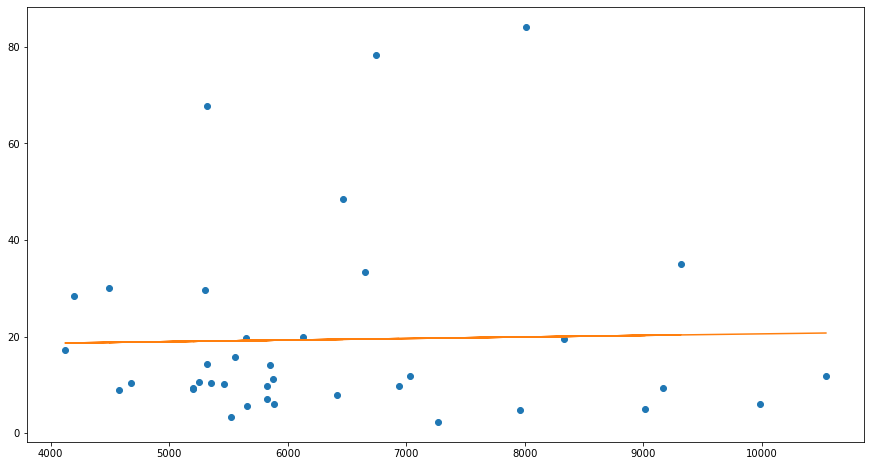

In [589]:
# Plot data
plt.figure(figsize=(15,8))
plt.plot(data_small['Alle-Total'], data_small['Exposure'], 'o')
m, b = np.polyfit(data_small['Alle-Total'], data_small['Exposure'], 1)
plt.plot(data_small['Alle-Total'], m*data_small['Alle-Total'] + b)

In [590]:
# calc correlation between 'mean income' and 'Proximity'
data_small[['Alle-Total', 'Proximity']].corr()

,Alle-Total,Proximity
Alle-Total,1.000000,-0.307507
Proximity,-0.307507,1.000000


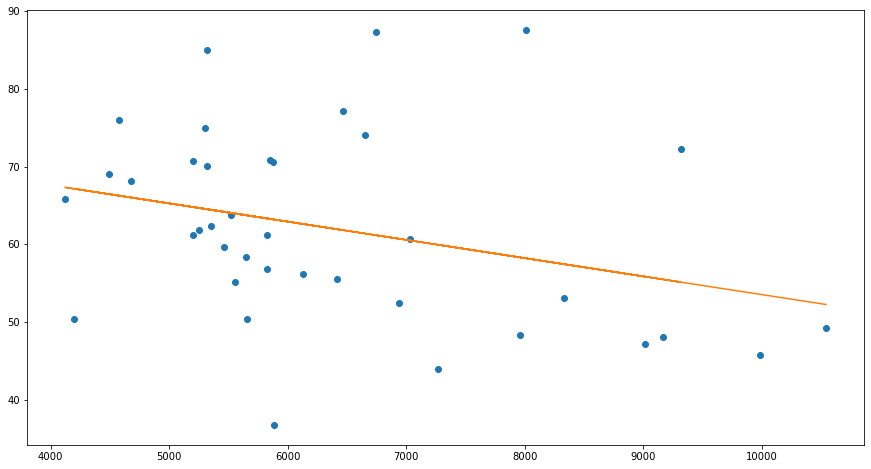

In [591]:
# plot data
plt.figure(figsize=(15,8))
plt.plot(data_small['Alle-Total'], data_small['Proximity'], 'o')
m, b = np.polyfit(data_small['Alle-Total'], data_small['Proximity'], 1)
plt.plot(data_small['Alle-Total'], m*data_small['Alle-Total'] + b)

---

## Daten speichern für Weiterverarbeitung speichern

In [592]:
## export data for further processing in R
data_small[['ISCO', 'Beruf', 'Alle-Total', 'Exposure', 'Proximity', 'Exp_Prox', 'n (in Tausend)']].reset_index().to_feather("internal/data_small.feather")

In [593]:
## export data for visualization
data_small[['ISCO', 'Beruf', 'Alle-Total', 'Exposure', 'Proximity', 'Exp_Prox', 'Frauenanteil', 'n (in Tausend)']].to_csv("output/jobs_groups.csv", index=False)

---

## Durchschnittliches Ansteckungsrisiko pro Geschlecht berechnen

In [625]:
## calculate average 'risk' per gender across all jobs
n_risk = []

# calculate number of men and women per job and assign risk
for i, row in data[~pd.isnull(data.Exp_Prox) & (~pd.isnull(data.Frauenanteil))].iterrows():
    n_women = row['Total (in T)'] / 100 * row['Frauenanteil']
    n_men = row['Total (in T)'] / 100 * (100 - row['Frauenanteil'])
    risk = row['Exp_Prox']
    n_risk.append([n_women, n_men, risk])
n_risk = pd.DataFrame(n_risk, columns=["n_women", "n_men", "risk"])

# calculate weighted average of risk per gender
risk_women = 0
risk_men = 0
for i, row in n_risk.iterrows():
    risk_women += row['n_women'] * row['risk']
    risk_men += row['n_men'] * row['risk']
risk_women = risk_women / n_risk.n_women.sum()
risk_men = risk_men / n_risk.n_men.sum()

print(f'Ø-Ansteckungsrisiko Frauen: {risk_women}')
print(f'Ø-Ansteckungsrisiko Männer: {risk_men}')
print(f'Durschnittliches Ansteckingsrisiko liegt bei Frauen um {((100 / risk_men * risk_women)-100):.2f}% höher')

Ø-Ansteckungsrisiko Frauen: 47.805757034614324
Ø-Ansteckungsrisiko Männer: 37.30561107346061
Durschnittliches Ansteckingsrisiko liegt bei Frauen um 28.15% höher
